In [1]:
#Для построения архитектуры ESN использовалась библиотека reservoirPy, основанная на графовых вычислениях
import numpy as np
import matplotlib.pyplot as plt
from reservoirpy.datasets import to_forecasting # разбиение на train/test
import reservoirpy as rpy
from reservoirpy.nodes import Reservoir, Ridge #узлы резервуара и считывающего слоя
from reservoirpy.observables import nrmse, rsquare
import json
from scipy.integrate import solve_ivp

In [28]:
def train_test(X_train, y_train, X_test, y_test):
    sample = 2000
    test_len = X_test.shape[0]
    fig = plt.figure(figsize=(15, 5))
    plt.plot(np.arange(0, 2000), X_train[-sample:], label="X_train")
    plt.plot(np.arange(0, 2000), y_train[-sample:], label="y_train")
    plt.plot(np.arange(2000, 2000+test_len), X_test, label="X_test")
    plt.plot(np.arange(2000, 2000+test_len), y_test, label="y_test")
    plt.xlabel(r'$t$')
    plt.legend()
    plt.show()
    
def results(y_pred, y_test, sample=1500):
    fig = plt.figure(figsize=(15, 7))
    ax = plt.subplot(211)
    ax.plot(np.arange(sample), y_test[len(y_test)-sample:], lw=2, label="True value", color="black")
    ax.plot(np.arange(sample), y_pred[len(y_pred)-sample:], lw=3, label="ESN prediction", color="gray", linestyle="--")
    ax.axvline(x=sample-10, color="red")  # Add vertical line
    
    ax.legend()
    plt.show()

In [2]:
###ПОДГОТОВКА ДАННЫХ
#9
import warnings
from nolitsa import data
dt = 0.01
x0 = [0.62225717, -0.08232857, 30.60845379]


x = data.lorenz(length=4000, sample=dt, x0=x0,
               sigma=16.0, beta=4.0, rho=45.92)[1]

In [3]:
x.shape

(4000, 3)

In [4]:
#11
import copy
time = copy.deepcopy(x) #берем значения Лоренца
X = time[:,0] #берем только x
X = X.reshape(4000,1) #зачем-то 
X = 2 * (X - X.min()) / (X.max() - X.min()) - 1 #нормализация(?)

In [5]:
X.shape

(4000, 1)

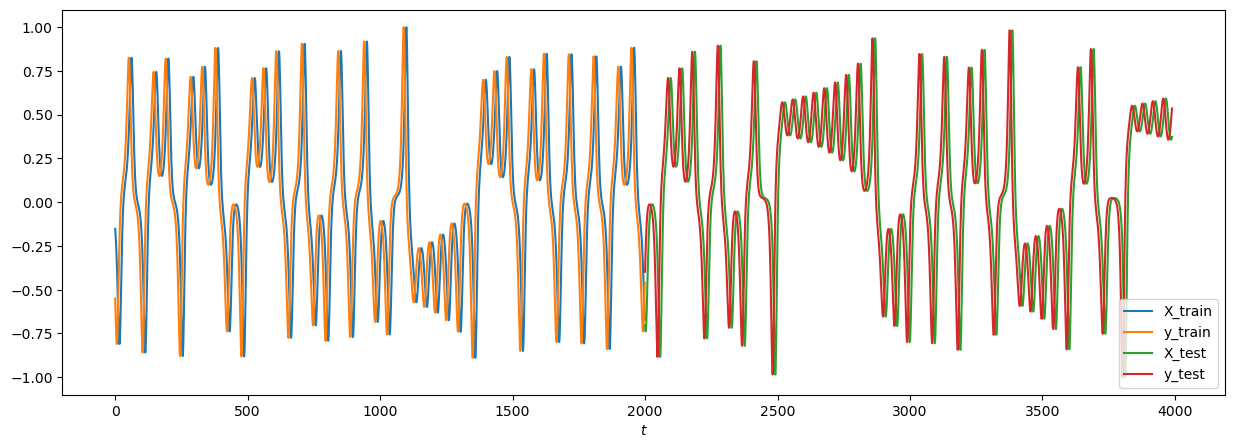

In [7]:
###HERE0
from reservoirpy.datasets import to_forecasting

x, y = to_forecasting(X, forecast=10)

X_train1, y_train1 = x[:2000], y[:2000]
X_test1, y_test1 = x[2000:], y[2000:]

train_test(X_train1, y_train1, X_test1, y_test1)

In [13]:
X_train1.shape 

(2000, 1)

In [15]:
y_train1.shape 

(2000, 1)

In [17]:
X_test1.shape

(1990, 1)

In [18]:
y_test1.shape

(1990, 1)

y это x, сдвинутый на 10 делений вправо, но от куда он знает, что будеть справа от x? Посмотрим, как это выглядит.

In [10]:
x.shape

(3990, 1)

In [11]:
y.shape

(3990, 1)

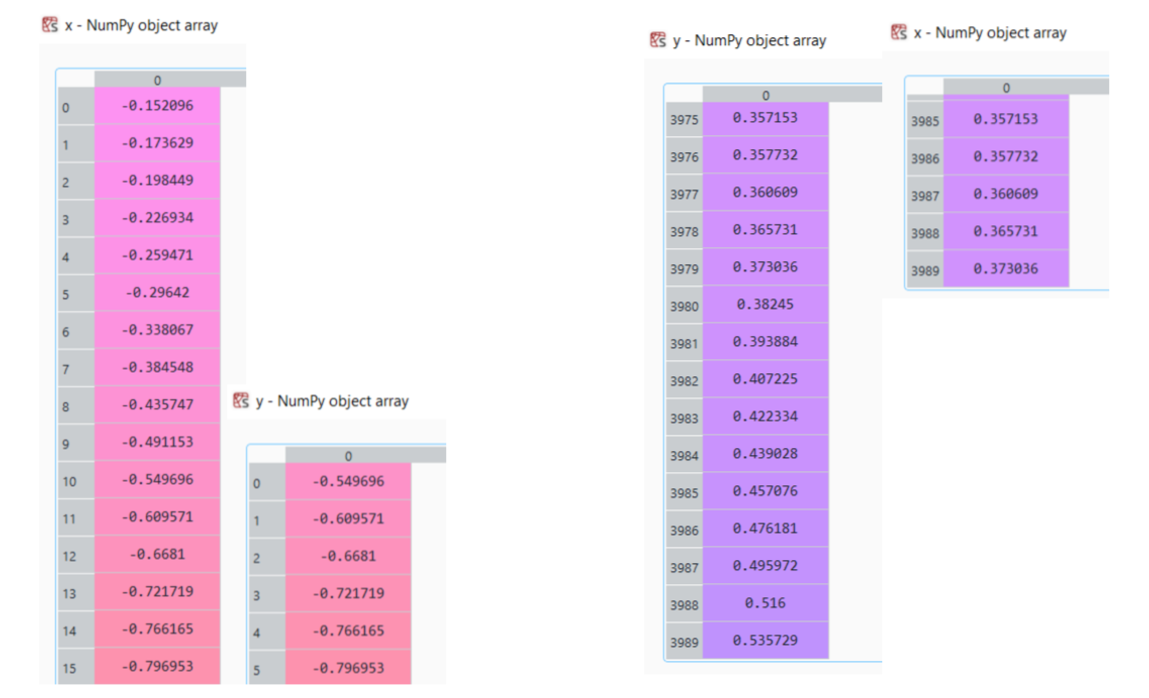

In [12]:
#Первый тестовый набор параметров 
units = 100
leak_rate = 0.3
spectral_radius = 1.25
input_scaling = 1.0
connectivity = 0.1
input_connectivity = 0.2
regularization = 1e-8
seed = 1234

#узел резервуара
reservoir = Reservoir(units, input_scaling=input_scaling, sr=spectral_radius,
                      lr=leak_rate, rc_connectivity=connectivity,
                      input_connectivity=input_connectivity, seed=seed)
#выходной слой(считывающее устройство)
readout = Ridge(1, ridge=regularization) # 1 - кол-во выходных нейронов
#соединяем узлы и таким образом получаем модель 
esn = reservoir >> readout

Running Model-0:   0%|                                                                           | 0/1 [00:00<?, ?it/s]
Running Model-0: 433it [00:00, 4287.14it/s]                                                                            
Running Model-0: 896it [00:00, 4462.15it/s]
Running Model-0: 1343it [00:00, 4290.54it/s]
Running Model-0: 2000it [00:00, 4219.64it/s]
Running Model-0: 100%|███████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.00it/s]


Fitting node Ridge-0...


Running Model-0: 1990it [00:00, 4261.08it/s]                                                                           


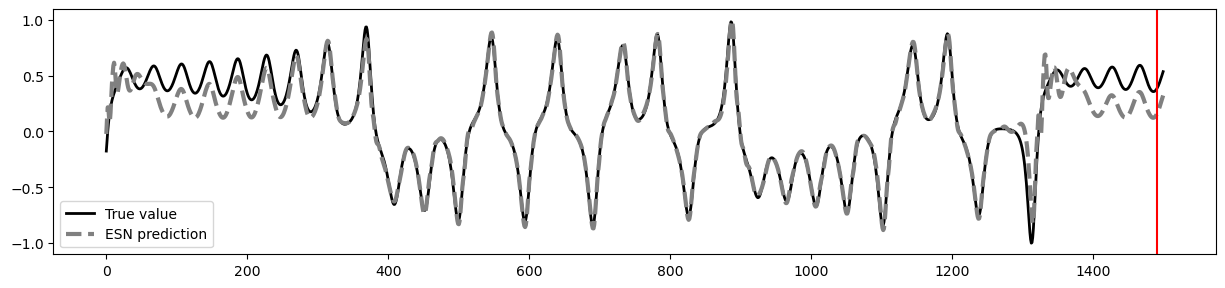

In [31]:
#обучение модели
esn = esn.fit(X_train1, y_train1)
#делаем предсказание
y_pred1 = esn.run(X_test1)
results(y_pred1, y_test1, sample=1500)
###HERE1

In [30]:
y_pred1.shape

(1990, 1)